In [1]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io #para usar streams de dados na memória (sem precisar salvar arquivos no disco)
import base64 #para codificar dados binários (como imagens) em texto
import folium #biblioteca de mapa interativo

In [2]:
#Leitura do dataset auxilios tratado
auxilios = pd.read_csv('dados/dados_limpos.csv')

#Leitura do dataset de dados populacional tratado
populacao = pd.read_csv('dados/dados_populacional_limpo.csv')

## PLOTAGENS - Pietra

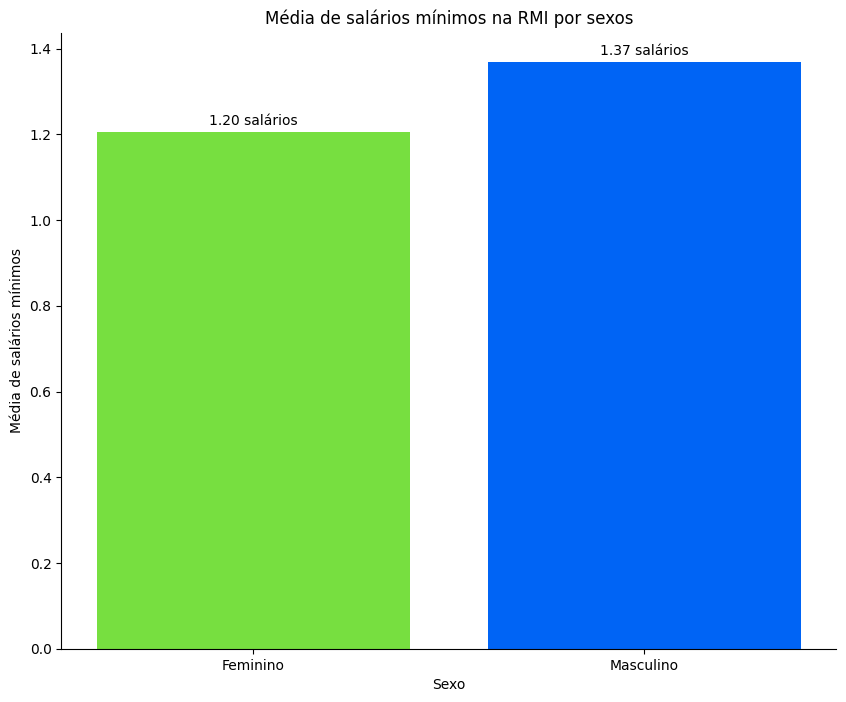

In [3]:
#pega a linha onde sexo = feminino e depois pega a quant de salarios dessas linhas
media_fem = auxilios.loc[auxilios['Sexo'] == 'Feminino', 'Quant salarios minimos na RMI'].mean()
media_masc = auxilios.loc[auxilios['Sexo'] == 'Masculino', 'Quant salarios minimos na RMI'].mean()

diferenca = abs(media_fem - media_masc)

fig, ax = plt.subplots(figsize=(10, 8))

barras = ax.bar(['Feminino', 'Masculino'],
    [media_fem, media_masc],
    color=['#77DF40', '#0064F5']
)

ax.set_title('Média de salários mínimos na RMI por sexos')
ax.set_xlabel('Sexo')
ax.set_ylabel('Média de salários mínimos')
ax.bar_label(barras, fmt='%.2f salários', padding=3)

ax.spines['top'].set_visible(False) #borda
ax.spines['right'].set_visible(False) 

plt.show()


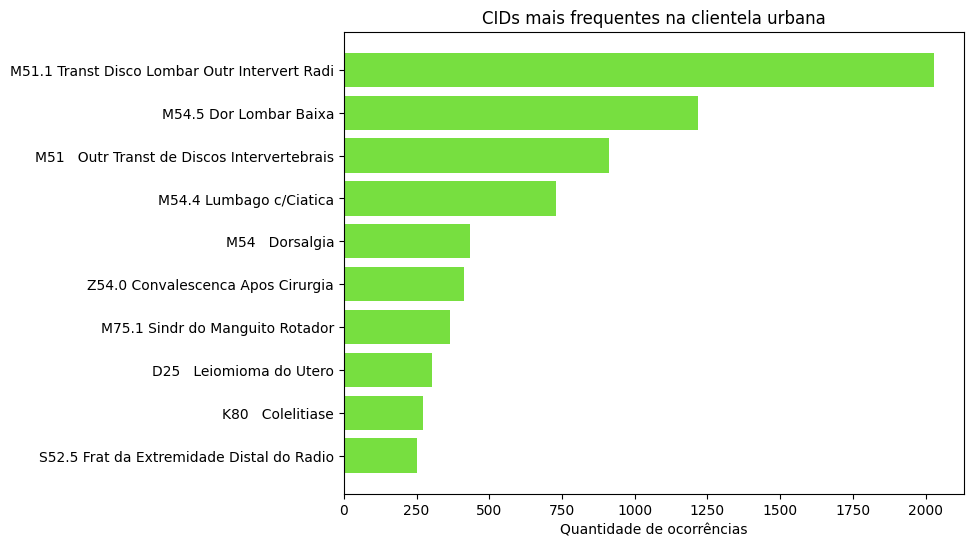

In [4]:
#filtrando e tirando os cid 'vazios'
cli_urbana = auxilios.loc[auxilios['Clientela'] == 'Rural', 'CID']
cli_urbana = cli_urbana[~cli_urbana.isin(['Zerados', 'Em Branco', '{ñ class}'])] #mantem somente os CIDs que nao estao nessa condição

contagem = cli_urbana.value_counts().head(10).sort_values(ascending=True)
plt.figure(figsize=(8,6))
plt.barh(contagem.index,
        contagem.values,
        color='#77DF40'
        )
plt.title('CIDs mais frequentes na clientela urbana')
plt.xlabel('Quantidade de ocorrências')

plt.show()


In [5]:
proporcao = (auxilios.groupby('UF')['Forma Filiação'] #agrupa por uf, pega a coluna forma filiação
                        .value_counts(normalize=True) #normaliza para retornar as proporções
                        .unstack(fill_value=0) #Antes retornava uma Series, que tem indice multinivel, as linhas eram combinações de UF e de Forma de Filiação, e agora é um DataFrame, com as linhas sendo os uf e as colunas as formas de filiação. E coloca 0 
                        )

In [6]:
coordenadas_uf = {
    'Acre': [-9.0238, -70.812],   'Alagoas': [-9.5713, -36.782],
    'Amapá': [0.9020, -52.003],    'Amazonas': [-3.4168, -65.8561],
    'Bahia': [-12.5797, -41.7007], 'Ceará': [-5.4984, -39.3206],
    'Distrito Federal': [-15.7801, -47.9292], 'Espírito Santo': [-19.1834, -40.3089],
    'Goiás': [-15.8270, -49.8362], 'Maranhão': [-4.9609, -45.2744],
    'Mato Grosso': [-12.6819, -56.9211], 'Mato Grosso do Sul': [-20.7722, -54.7852],
    'Minas Gerais': [-18.5122, -44.555],  'Pará': [-1.9981, -54.9306],
    'Paraíba': [-7.2399, -36.782],   'Paraná': [-24.89, -51.55],
    'Pernambuco': [-8.8137, -36.9541],  'Piauí': [-6.6695, -42.28],
    'Rio de Janeiro': [-22.9099, -43.2095], 'Rio Grande do Norte': [-5.4026, -36.9541],
    'Rio Grande do Sul': [-30.0346, -51.2177], 'Rondônia': [-10.83, -63.34],
    'Roraima': [2.7376, -62.0751],   'Santa Catarina': [-27.2423, -50.2189],
    'Sergipe': [-10.5741, -37.3857], 'São Paulo': [-23.5505, -46.6333],
    'Tocantins': [-10.1753, -48.2982]
}


In [7]:
cores_filiacao = {
    'Autônomo': '#E74C3C',           # Vermelho vibrante
    'Desempregado': '#3498DB',       # Azul royal
    'Doméstico': '#1ABC9C',          # Verde turquesa
    'Empregado': '#673AB7',          # Roxo escuro 
    'Empresário': '#F39C12',         # Laranja forte
    'Equiparado a Autônomo': '#95A5A6',  # Cinza médio
    'Facultativo': '#E91E63',        # Rosa pink
    'Optante Pela Lei 6.184/74': '#9B59B6',  # Roxo 
    'Segurado Especial': '#FF9800',  # Laranja âmbar
    'Trabalhador Avulso': '#2ECC71'  # Verde esmeralda 
}

In [8]:
def criar_grafico_pizza(valores, labels): #valores = proporções ----- labels = categorias
    cores = [cores_filiacao.get(label, '#CCCCCC') for label in labels]
    
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.pie(valores, labels=None, startangle=90, colors=cores)
    ax.axis('equal') #circulo e nao oval
    
    buffer = io.BytesIO() #maquina virtual, não salva no disco, só na memória temporária

    plt.savefig(buffer, format='png', bbox_inches='tight', transparent=True) #bbox_inches='tight' -> remove espaços em branco ao redor do gráfico
    buffer.seek(0) #rebobina buffer para o inicio
    plt.close(fig)
    
    imagem_base64 = base64.b64encode(buffer.read()).decode() #o buffer le as dados binarios da imagem, converte em texto e transforma de byte para string
    return f'data:image/png;base64,{imagem_base64}' #retorna a string formatada e cola a strind da imagem


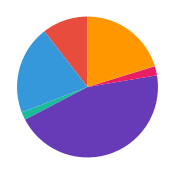
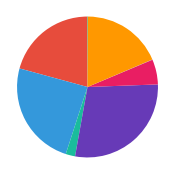
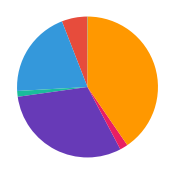
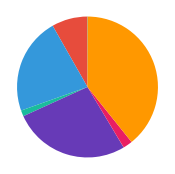
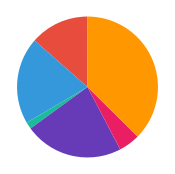
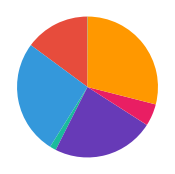
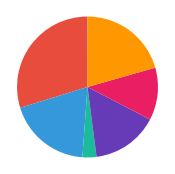
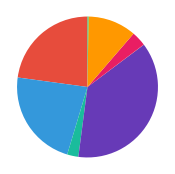
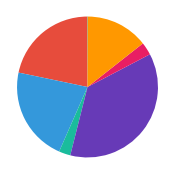
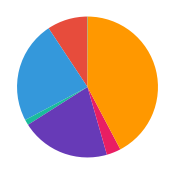
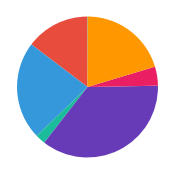
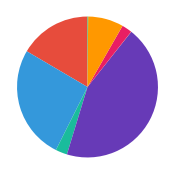
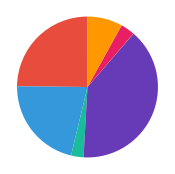
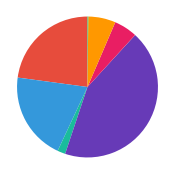
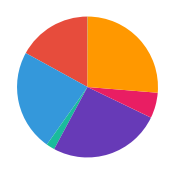
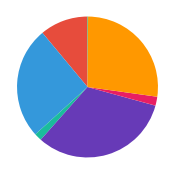
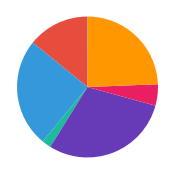
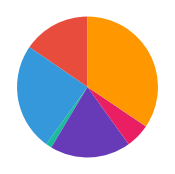
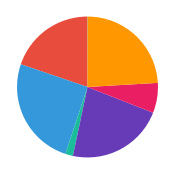
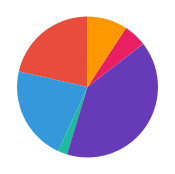
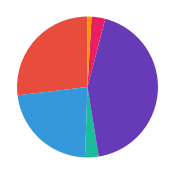
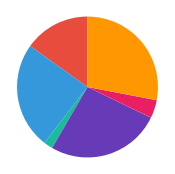
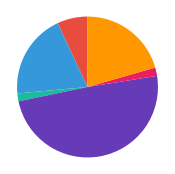
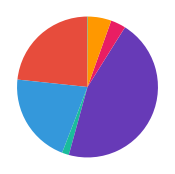
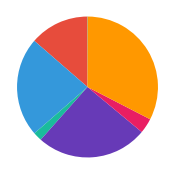
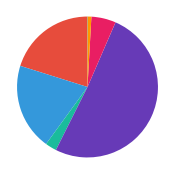
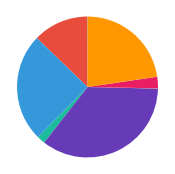

In [9]:
mapa = folium.Map(
    location=[-15.7801, -47.9292],
    zoom_start=4,
    tiles='OpenStreetMap'
)

for uf_nome in proporcao.index: #percorre cada UF que está no índice do dataframe proporcao
    if uf_nome in coordenadas_uf:
        valores = proporcao.loc[uf_nome] #pega as proporções de cada forma de filiação naquele estado e retorna uma Serie
        valores = valores[valores > 0]
        
        if len(valores) > 0:
            #gera o gráfico
            #values = numeros/proporcoes ----- index = nomes das categotias
            imagem = criar_grafico_pizza(valores.values, valores.index)
            
            #cria tabela do popup
            tabela_html = '<table style="width:100%; font-size:11px;">'

            #legenda do popup
            for label, valor in zip(valores.index, valores.values): #label recebe o nome e valor o numero. O zip junta as duas listas, como se fosse uma tupla(pares) 
                cor = cores_filiacao.get(label, '#CCC')
                tabela_html += f'''
                <tr>
                    <!--faz o quadradinho colorido-->
                    <td><span style="background:{cor}; width:12px; height:12px;
                                     display:inline-block; border:1px solid #000;"></span></td>

                    <!--nome da categoria-->
                    <td>{label}</td>

                    <!--a porcentagem-->
                    <td style="text-align:right;"><b>{valor*100:.1f}%</b></td>
                </tr>
                '''
            tabela_html += '</table>'
            
            #conteudo do popup
            popup_html = f'''
            <!--div que vai agrupar, alinhando no centro e com tamanho minimo-->
            <div style="text-align:center; min-width:250px;">
                <!--titulo com o estado-->
                <h4 style="margin:5px 0;">{uf_nome}</h4>

                <!--grafico de pizza-->
                <img src="{imagem}" width="150" height="150">

                <!--linha horizontal para dividir-->
                <hr style="margin:10px 0;">

                <!--insere conteudo da variavel -> que é a legenda-->
                {tabela_html}
            </div>
            '''

            #adiciona um círculo no mapa
            folium.CircleMarker(
                location=coordenadas_uf[uf_nome],
                radius=5,
                color='#4E684E',
                fill=True,
                fillColor='#A8DCAB',
                fillOpacity=0.6,
                popup=folium.Popup(popup_html, max_width=250)
            ).add_to(mapa)
            
mapa

## PLOTAGENS - Sabrina

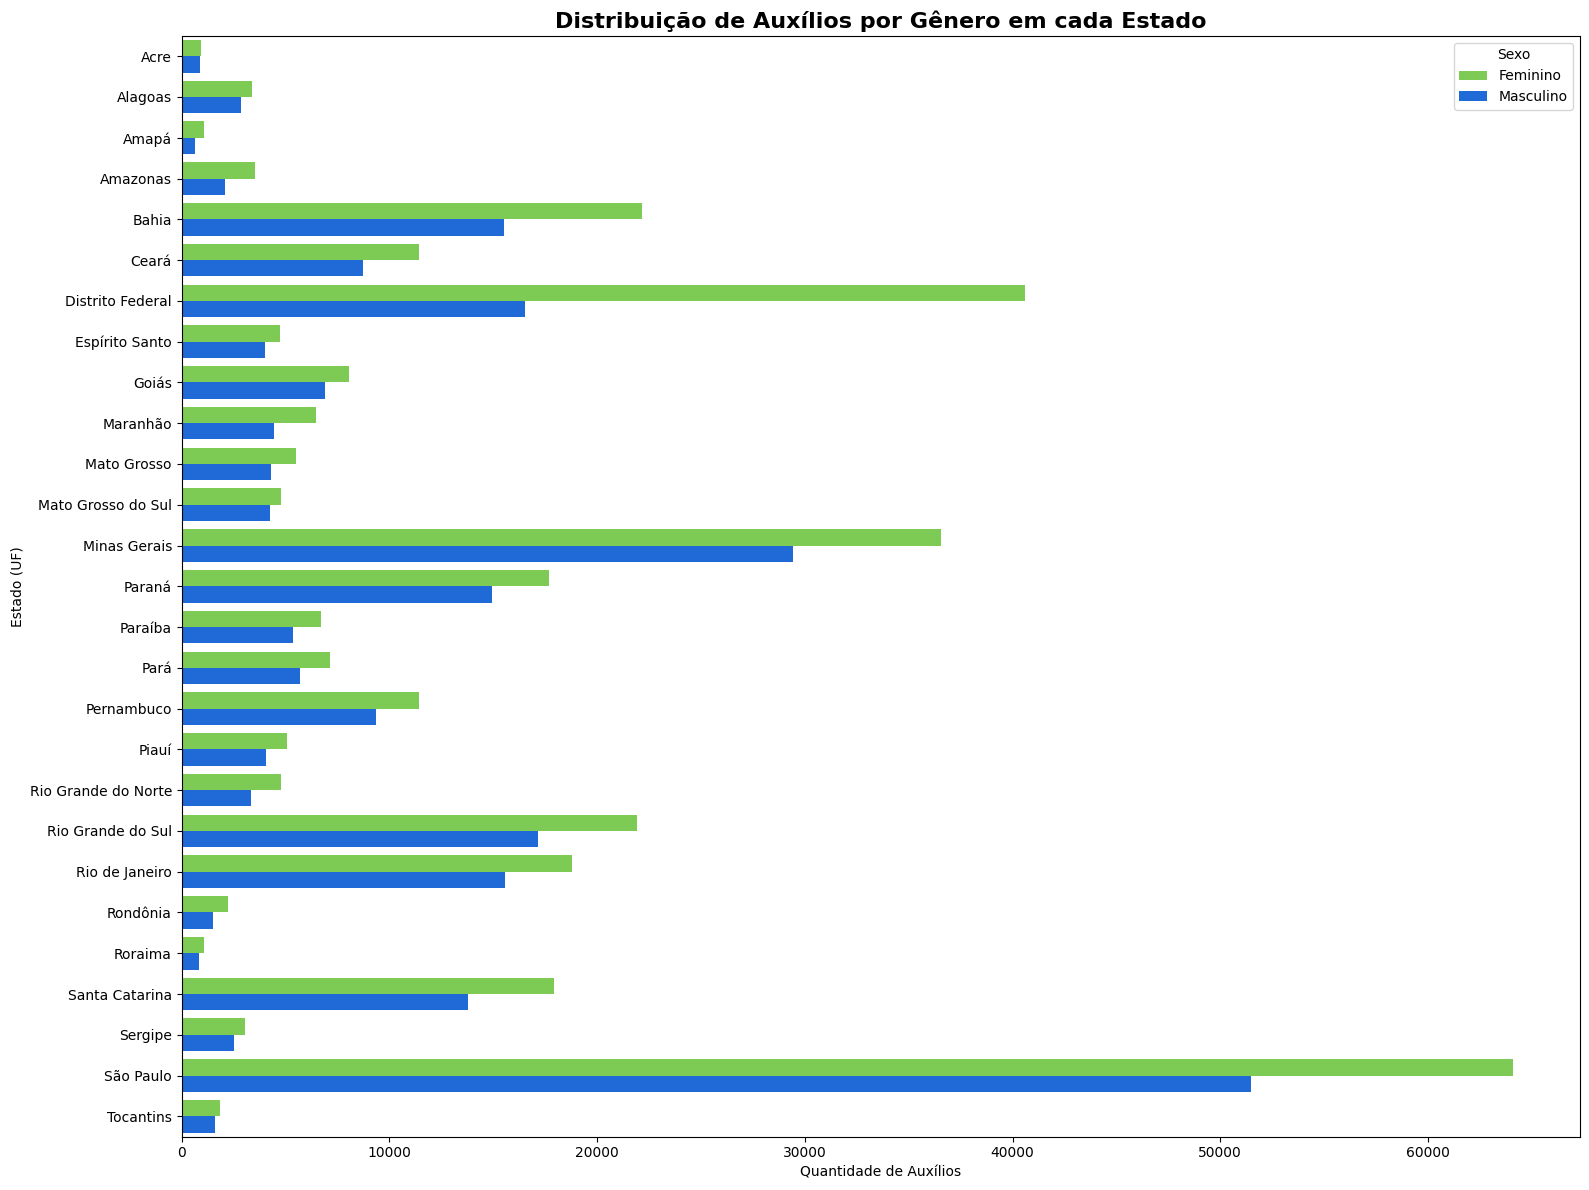

In [10]:
#Cria df com total de auxilios por gênero em cada estado
df_generos_por_UF = (auxilios.groupby(['UF', 'Sexo'])
                     .size()
                     .reset_index(name='Total de Auxilios Concedidos'))

#Exibe a comparação de distribuição de auxilio por gênero em cada Estado
plt.figure(figsize=(16,12))
sns.barplot(
    data=df_generos_por_UF,
    y='UF',
    x='Total de Auxilios Concedidos',
    hue='Sexo',
    palette=['#77DF40', '#0064F5']
)
plt.title('Distribuição de Auxílios por Gênero em cada Estado', fontweight='bold',fontsize=16)
plt.xlabel('Quantidade de Auxílios')
plt.ylabel('Estado (UF)')
plt.legend(title='Sexo')
plt.tight_layout()
plt.show()

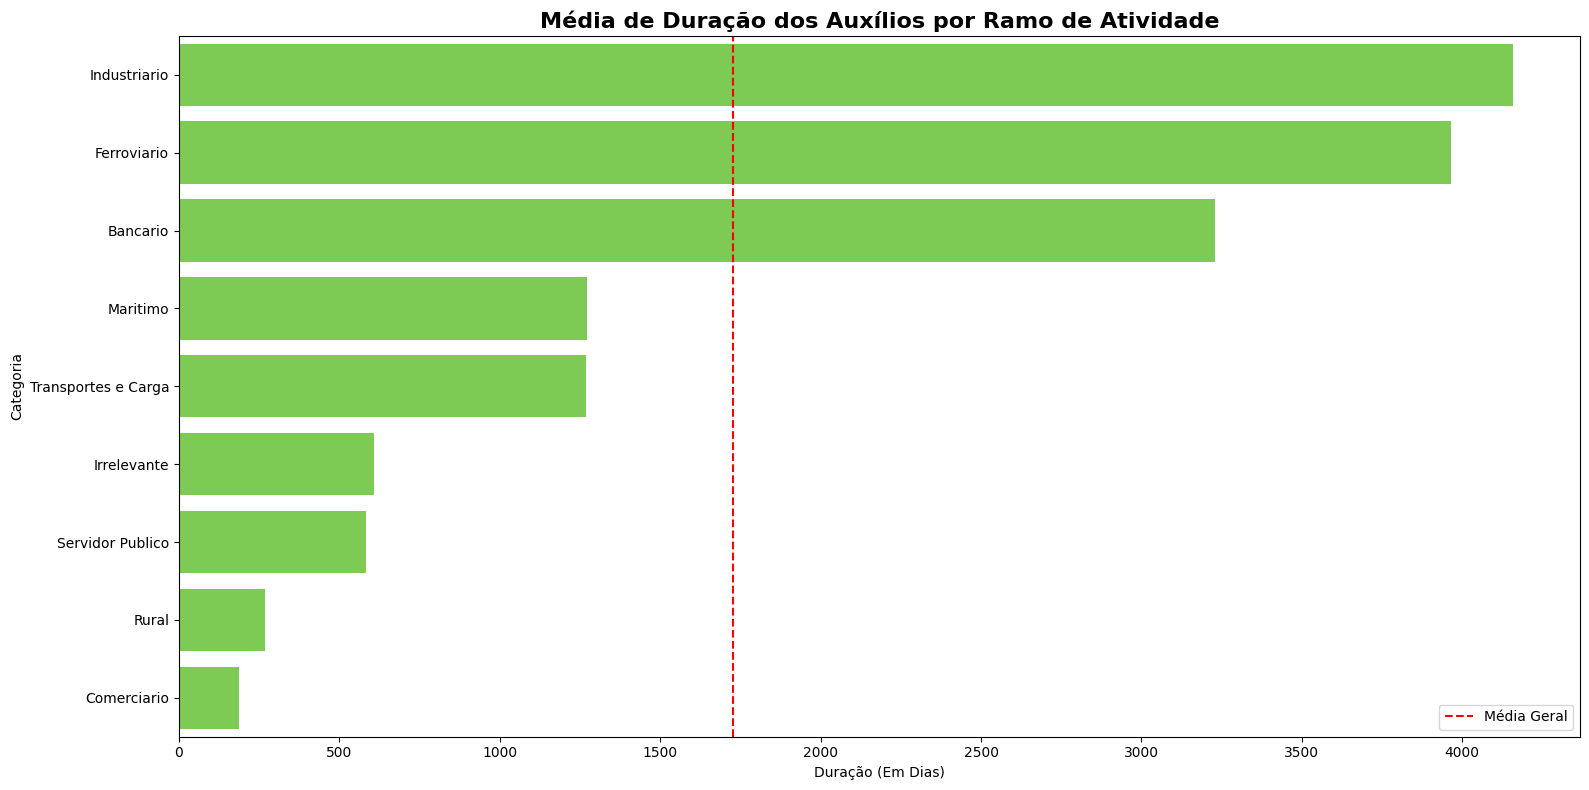

In [11]:
#Cria e calcula a duração do auxilio
auxilios['Data DIB'] = pd.to_datetime(auxilios['Data DIB'])
auxilios['Data DCB'] = pd.to_datetime(auxilios['Data DCB'])

auxilios['Duração'] = auxilios['Data DCB'] - auxilios['Data DIB']

#Cria um df com a média de dias de duração de beneficio por profissão
df_media_profissao = auxilios.groupby('Ramo Atividade')['Duração'].mean().reset_index()
df_media_profissao['Duração'] = df_media_profissao['Duração'].dt.days
df_media_profissao = df_media_profissao.sort_values('Duração', ascending=False)

#Exibe Média de duração dos auxilios por Ramo de Atividade
plt.figure(figsize=(16,8))
sns.barplot(
    data=df_media_profissao,
    y='Ramo Atividade',
    x='Duração',
    color='#77DF40',
)

plt.axvline(x=df_media_profissao['Duração'].mean(), color='red', linestyle='--', 
            label=f'Média Geral')

plt.title('Média de Duração dos Auxílios por Ramo de Atividade',fontweight='bold', fontsize=16)
plt.xlabel('Duração (Em Dias)')
plt.ylabel('Categoria')
plt.legend()
plt.tight_layout()
plt.show()

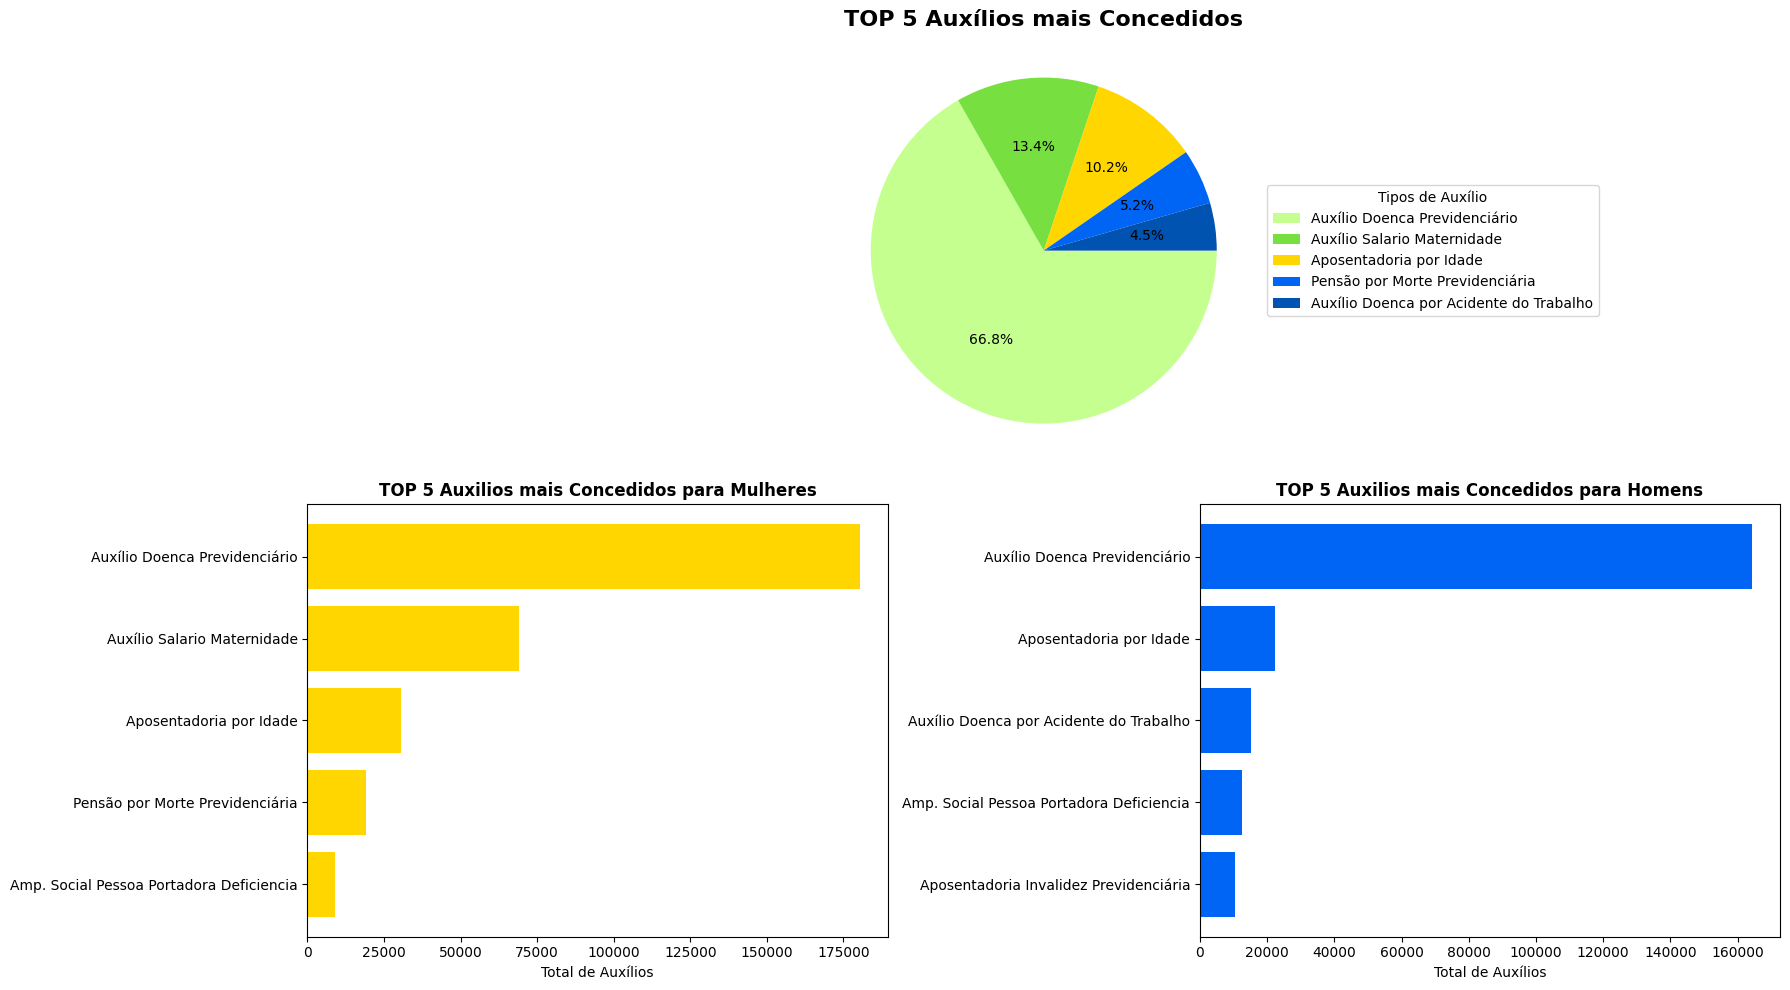

In [64]:
#Cria df com top5 auxilios mais concedidos
top5_geral = auxilios['Tipos de auxilio'].value_counts().head(5).reset_index()
top5_geral.columns = ['Tipo', 'Total de Auxílios']
top5_geral['Categoria'] = 'Geral'

#Cria df com top5 auxilios mais concedidos para mulheres
top5_mulheres = (auxilios[auxilios['Sexo'] == 'Feminino']['Tipos de auxilio']
                 .value_counts()
                 .head(5)
                 .reset_index())
top5_mulheres.columns = ['Tipo', 'Total de Auxílios']
top5_mulheres['Categoria'] = 'Feminino'

#Cria df com top5 auxilios mais concedidos para homens
top5_homens = (auxilios[auxilios['Sexo'] == 'Masculino']['Tipos de auxilio']
               .value_counts()
               .head(5)
               .reset_index())
top5_homens.columns = ['Tipo', 'Total de Auxílios']
top5_homens['Categoria'] = 'Masculino'

#Exibe o Top 5 auxilios mais concedidos
fig = plt.figure(figsize=(18, 10))

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1.pie(top5_geral['Total de Auxílios'], 
    autopct='%1.1f%%', 
    colors=['#C5FF90','#77DF40','#FFD600','#0064F5','#0053b0'])
ax1.set_title('TOP 5 Auxílios mais Concedidos', fontsize=16,fontweight='bold')
ax1.legend(title='Tipos de Auxílio', labels=top5_geral['Tipo'], loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
ax1.invert_yaxis()

ax2 = plt.subplot2grid((2, 2), (1, 0))
ax2.barh(top5_mulheres['Tipo'], top5_mulheres['Total de Auxílios'], color='#FFD600')
ax2.set_title('TOP 5 Auxilios mais Concedidos para Mulheres', fontweight='bold')
ax2.set_xlabel('Total de Auxílios')
ax2.invert_yaxis()

ax3 = plt.subplot2grid((2, 2), (1, 1))
ax3.barh(top5_homens['Tipo'], top5_homens['Total de Auxílios'], color='#0064F5')
ax3.set_title('TOP 5 Auxilios mais Concedidos para Homens', fontweight='bold')
ax3.set_xlabel('Total de Auxílios')
ax3.invert_yaxis()

plt.tight_layout()
plt.show()

Média de Duração do Auxilio para o Público Feminino: 186 dias


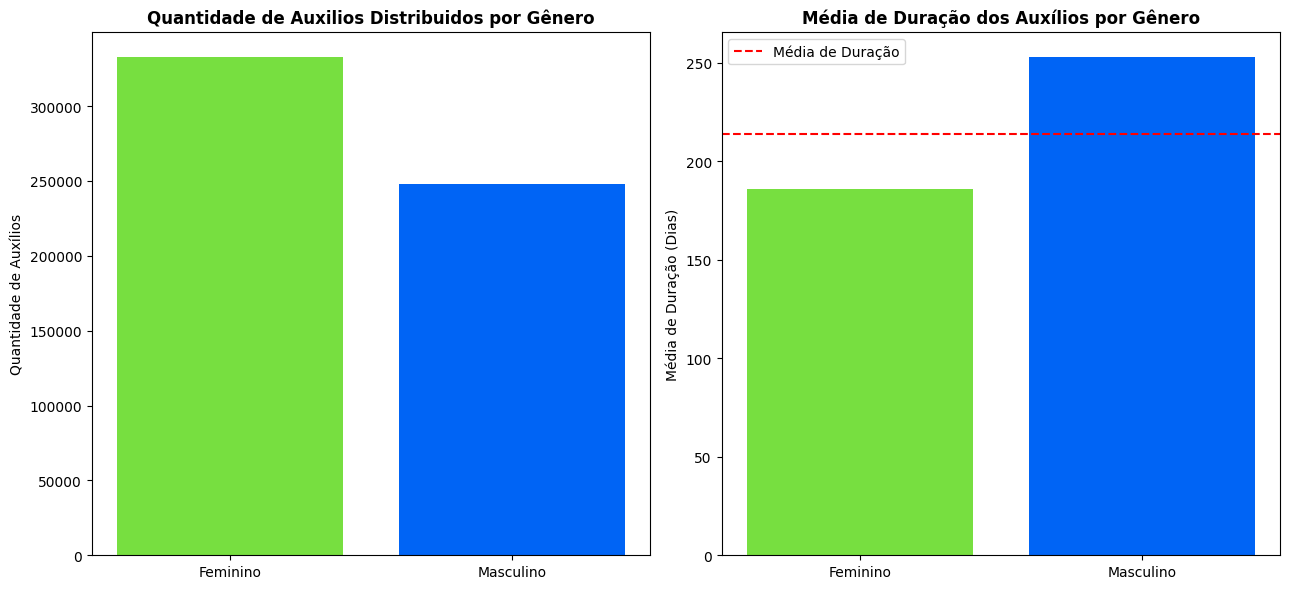

In [13]:
#Calcula a média de duração dos auxilios
media_duracao_auxilios = auxilios['Duração'].mean()
media_duracao_auxilios = media_duracao_auxilios.days

#Calcula a media de duração de auxilio para mulheres
media_duracao_mulheres = auxilios[auxilios['Sexo'] == 'Feminino']['Duração'].mean()
media_duracao_mulheres = media_duracao_mulheres.days

#Calcula a média de duração de auxilio para homens
media_duracao_homens = auxilios[auxilios['Sexo'] == 'Masculino']['Duração'].mean()
media_duracao_homens = media_duracao_homens.days

print(f"Média de Duração do Auxilio para o Público Feminino: {media_duracao_mulheres} dias")
#Calcula o total de auxilios concedidos para mulheres
total_auxilios_mulheres = (auxilios['Sexo'] == 'Feminino').sum()

#Calcula o total de auxilios concedidos para homens
total_auxilios_homens = (auxilios['Sexo'] == 'Masculino').sum()

#Cria df juntando os calculos feitos por genero em um df
juncao_medidas_genero = pd.DataFrame({
    'Categoria': ['Feminino', 'Masculino'],
    'Total de Auxílios': [total_auxilios_mulheres, total_auxilios_homens],
    'Média de Duração': [media_duracao_mulheres, media_duracao_homens]
    
})

#Exibe a quantidade, a média de duração e a média de RMI por gênero

fig = plt.figure(figsize=(13, 6))

ax1 = plt.subplot2grid((1, 2), (0, 0))
ax1.bar(juncao_medidas_genero['Categoria'], juncao_medidas_genero['Total de Auxílios'], color=['#77DF40','#0064F5'])
ax1.set_title('Quantidade de Auxilios Distribuidos por Gênero',fontweight='bold')
ax1.set_ylabel('Quantidade de Auxílios')


ax2 = plt.subplot2grid((1, 2), (0, 1))
ax2.bar(juncao_medidas_genero['Categoria'], juncao_medidas_genero['Média de Duração'], color=['#77DF40','#0064F5'])
ax2.axhline(y=media_duracao_auxilios, 
            color='red', 
            linestyle='--', 
            label=f'Média de Duração')
ax2.legend()
ax2.set_title('Média de Duração dos Auxílios por Gênero', fontweight='bold')
ax2.set_ylabel('Média de Duração (Dias)')

plt.tight_layout()
plt.show()

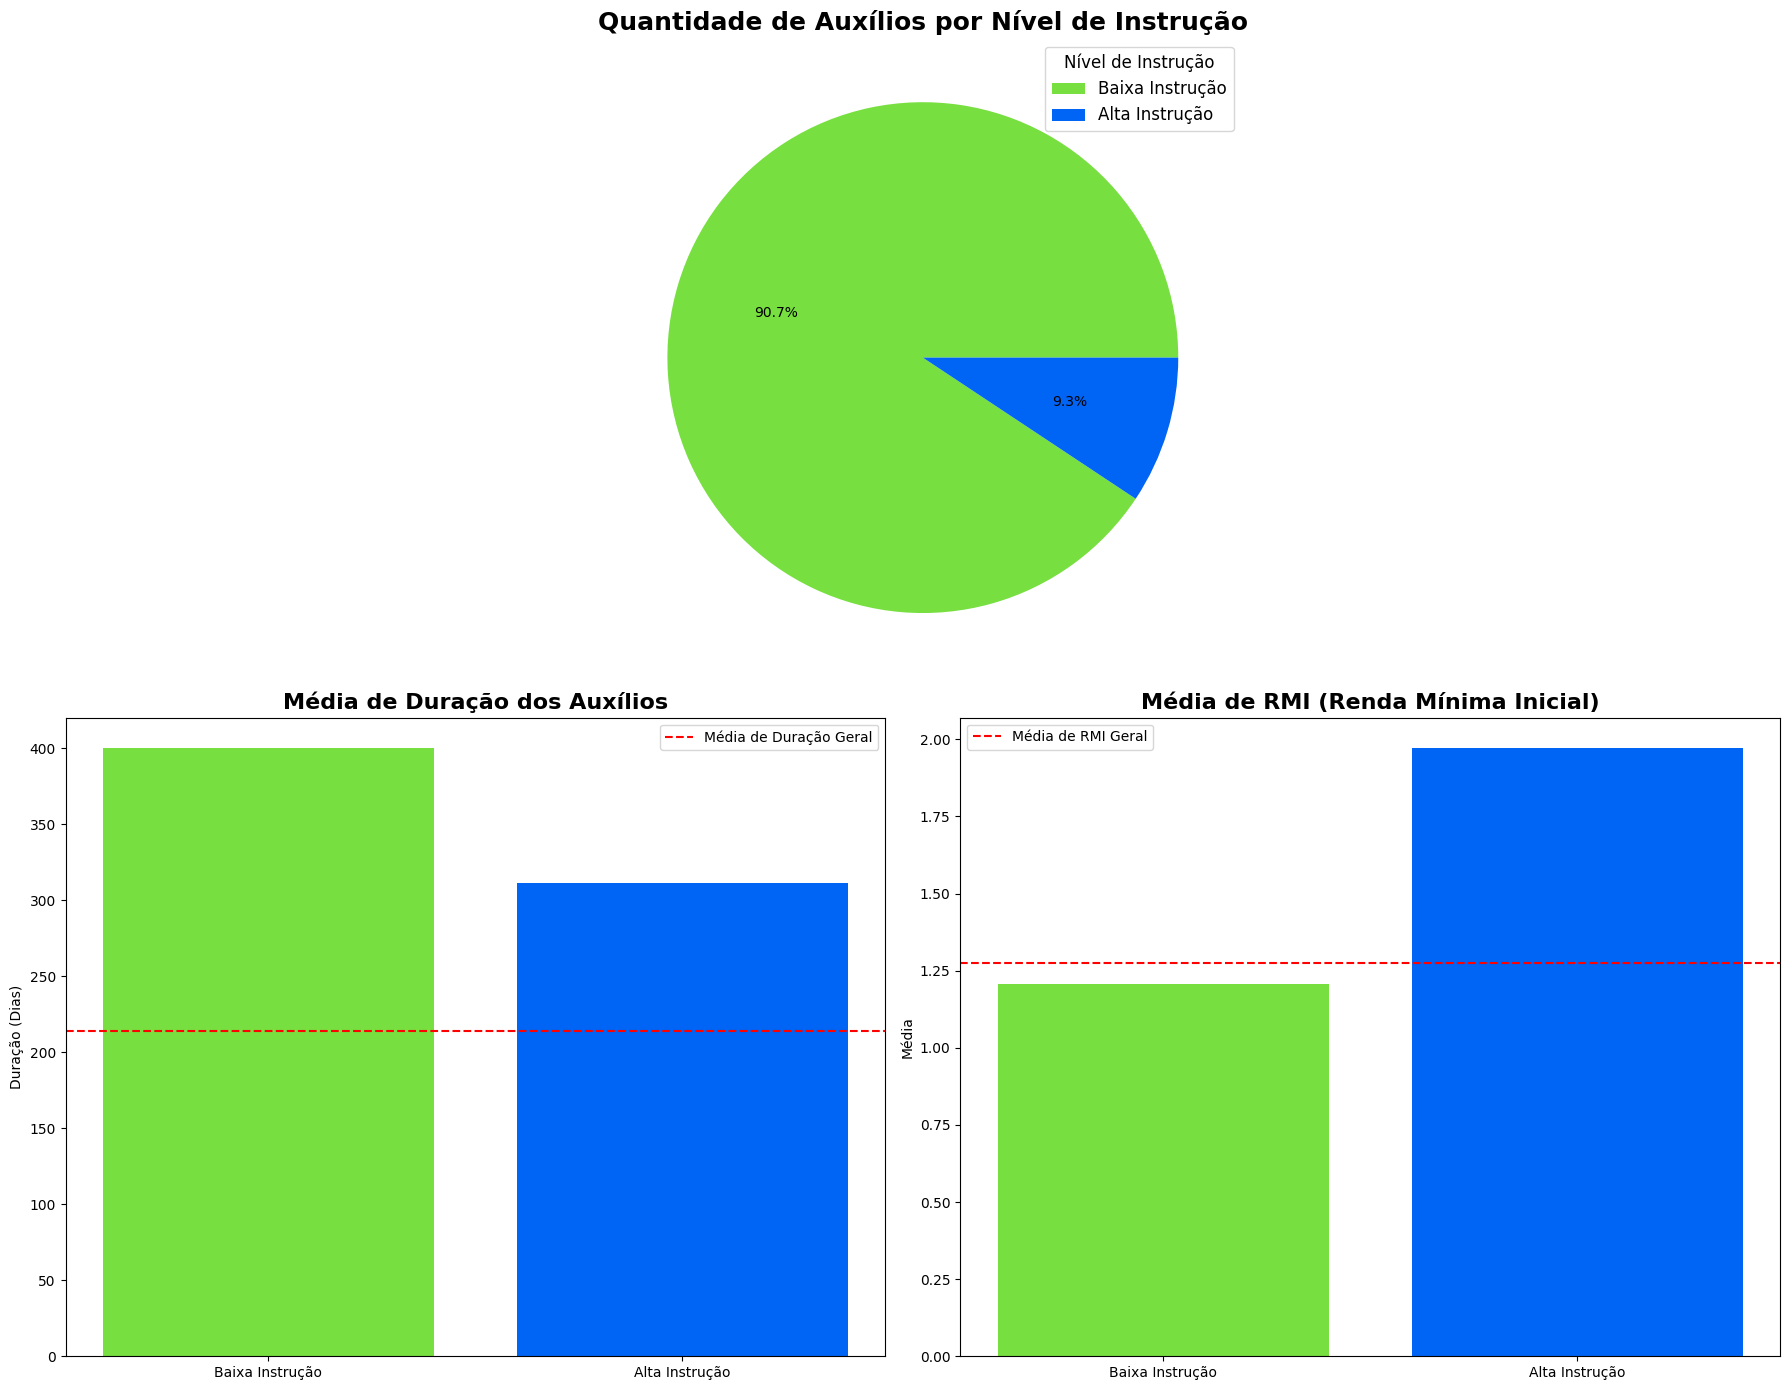

In [23]:
#Cria dataframes separados para comparar

graus_instrucao_alto = {
    'Superior Completo',
    'Superior Incompleto',
}

df_instrucao_alta = auxilios[
    auxilios['Grau Instrução'].isin(graus_instrucao_alto)
]
grau_instrucao_baixo = {
    '5ª. a 8ª. Série Incompl. do 1º. Grau   (Ginás',
    '2º. Grau (Colegial) Completo',
    '1º. Grau (Ginasial) Completo',
    '2º. Grau (Colegial) Incompleto',
    'Analfabeto',
    'Ate 4ª. Série 1º. Grau(Primário) Incompleta',
    '4ª. Série 1ª. Grau Completa'
}

df_instrucao_baixa = auxilios[
    auxilios['Grau Instrução'].isin(grau_instrucao_baixo)
]

#Calcula a média de duração dos benefícios para pessoas com alta instrução
media_duracao_instrucao_alta = df_instrucao_alta['Duração'].mean()
media_duracao_instrucao_alta = media_duracao_instrucao_alta.days

#Calcula a média de duração dos benefícios para pessoas com baixa instrução
media_duracao_instrucao_baixa = df_instrucao_baixa['Duração'].mean()
media_duracao_instrucao_baixa = media_duracao_instrucao_baixa.days

#Calcula a média de salarios minimos para pessoas com alta instrução
media_instrucao_alta = df_instrucao_alta['Quant salarios minimos na RMI'].mean()

#Calcula a média de salarios minimos para pessoas com baixa instrução
media_instrucao_baixa = df_instrucao_baixa['Quant salarios minimos na RMI'].mean()

#Calcula a média de RMI - Realmete necessário(?)
media_rmi = auxilios['Quant salarios minimos na RMI'].mean()

#Calcula a quantidade de auxilios por instrução alta
quantidade_auxilios_instrucao_alta = len(df_instrucao_alta)

#Calcula a quantidade de auxilios por instrução baixa
quantidade_auxilios_instrucao_baixa = len(df_instrucao_baixa)

#Cria um df com as informações com base na instrução
df_media_instrucao = pd.DataFrame({
    'Nível de Instrução': ['Baixa Instrução', 'Alta Instrução'],
    'Média RMI': [media_instrucao_baixa, media_instrucao_alta],
    'Média Duração': [ media_duracao_instrucao_baixa, media_duracao_instrucao_alta],
    'Quantidade de auxilios': [quantidade_auxilios_instrucao_baixa, quantidade_auxilios_instrucao_alta]
})

#Exibir Quantidade, média RMI e média de duração por instrução

fig = plt.figure(figsize=(18, 14))

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1.pie(df_media_instrucao['Quantidade de auxilios'], 
    autopct='%1.1f%%', 
    colors=['#77DF40','#0064F5'])
ax1.set_title('Quantidade de Auxílios por Nível de Instrução', fontweight='bold', fontsize=18)
ax1.legend(title ='Nível de Instrução', labels=df_media_instrucao['Nível de Instrução'],title_fontsize=12,fontsize=12)

ax2 = plt.subplot2grid((2, 2), (1, 0))
ax2.bar(df_media_instrucao['Nível de Instrução'], df_media_instrucao['Média Duração'], color=['#77DF40','#0064F5'])
ax2.axhline(y=media_duracao_auxilios, 
            color='red', 
            linestyle='--', 
            label=f'Média de Duração Geral')
ax2.legend()
ax2.set_title('Média de Duração dos Auxílios', fontweight='bold', fontsize=16)
ax2.set_ylabel('Duração (Dias)')

ax3 = plt.subplot2grid((2, 2), (1, 1))
ax3.bar(df_media_instrucao['Nível de Instrução'], df_media_instrucao['Média RMI'], color=['#77DF40','#0064F5'])
ax3.axhline(y=media_rmi, 
            color='red', 
            linestyle='--', 
            label=f'Média de RMI Geral')
ax3.legend()
ax3.set_title('Média de RMI (Renda Mínima Inicial)', fontweight='bold', fontsize=16)
ax3.set_ylabel('Média')

plt.tight_layout()
plt.show()